In [126]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set4 as invariant_set4
import cp_reach.satellite.plotting as plotting
import cp_reach.satellite.HCW as HCW
import cp_reach.satellite.TH_LTV as TH_LTV
import cp_reach.physics.rigid_body as rigid_body
import sympy as sp

import cp_reach.satellite.mission2 as sat_sim
import cyecca.lie as lie
import casadi as ca

import time

In [127]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
%autoreload 2

# Define Mission Parameters

In [129]:
thrust = 1000
duration = 20
ang_vel_dist_deg = 0.001 # in degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
gravity_err = 0.00 # m/s^2
accel_dist = 50 #m/s^2
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)
acc = [thrust, 0, 0]

In [130]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['a_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)

        
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['a_d_amp'] = accel_dist
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

# 10 Second Burn - Monte Carlo and Reference

In [131]:
def do_coast_reference(data_burn_ref, t_vect):
    sat_burn = sat_sim.SatSimBurn()
    sat_coast = sat_sim.SatSimCoast()
    sat_coast.model['p0_dict']['thrust'] = 0
    # initial conditions from end of burn
    for k in sat_coast.model['x0_dict']:
        sat_coast.model['x0_dict'][k] = data_burn_ref['xf'][sat_burn.model['x_index'][k], -1].full().squeeze()
    return sat_coast.simulate(t_vect, integrator='cvodes')

def do_coast_sim(data_burn, t_vect):
    data = []
    sat_burn = sat_sim.SatSimBurn()
    for r_burn in data_burn:
        sat_coast = sat_sim.SatSimCoast()
        # initial conditions from end of burn
        for k in sat_coast.model['x0_dict']:
            sat_coast.model['x0_dict'][k] = r_burn['xf'][sat_burn.model['x_index'][k], -1].full().squeeze()
        res = sat_coast.simulate(t_vect, integrator='cvodes')
        data.append(res)
    return data
def plotting_coast(data_coast_ref, data_coast):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plotting.plot_orbits(ax=ax, data_ref=data_coast_ref, data=data_coast)



In [132]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, duration, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

In [133]:
# Perform Simulation for Coast Phase
t_coast = np.arange(0, 3*24*3600, 60)
data_coast_ref = do_coast_reference(data_burn_ref=data_burn_ref, t_vect=t_coast)
data_coast = do_coast_sim(data_burn=data_burn, t_vect=t_coast)

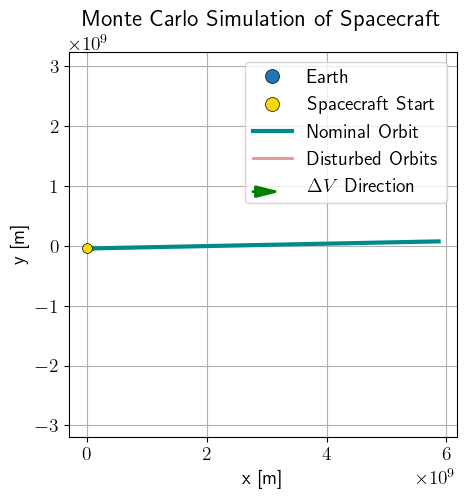

In [134]:

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True
def plotting_coast(data_coast_ref, data_coast):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plotting.plot_orbits(ax=ax, data_ref=data_coast_ref, data=data_coast)


plotting_coast(data_coast_ref=data_coast_ref, data_coast=data_coast)
plt.savefig("20s-10thrust-100dist-orbit.pdf", format="pdf", dpi=300)

## LMI for log-linearized system

In [135]:
%time
t0 = time.perf_counter()
xi_points, eta_points, bounds_log, sol = invariant_set4.solve(accel_dist, acc, control_gains, num_points=1000)
tf = time.perf_counter()
print(tf-t0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


/home/micah/miniconda3/envs/reach/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


42.02849341799447
42.02860377599427
43.847698843994294
43.84815404099936


In [136]:
bounds_log

array([[-29.69808997,  29.69808997],
       [-30.61703452,  30.6185006 ],
       [-30.65460134,  30.6475364 ],
       [-30.0998556 ,  30.0998556 ],
       [ -6.88830075,   6.85130262],
       [ -6.7799339 ,   6.87620636],
       [ -0.05532105,   0.05532103],
       [ -0.05540233,   0.05540233],
       [ -0.07386677,   0.07386677]])

In [137]:
xi_points, eta_points, bounds_log, sol = invariant_set4.solve(accel_dist, acc, control_gains, num_points=1000)
bounds_log

43.16373036899313
43.163871662996826
45.00704067100014


array([[-29.69808997,  29.69808997],
       [-30.61703452,  30.6185006 ],
       [-30.65460134,  30.6475364 ],
       [-30.0998556 ,  30.0998556 ],
       [ -6.88830075,   6.85130262],
       [ -6.7799339 ,   6.87620636],
       [ -0.05532105,   0.05532103],
       [ -0.05540233,   0.05540233],
       [ -0.07386677,   0.07386677]])

In [138]:
# i = 4
# j = 5
# plt.scatter(eta_points[i,:],eta_points[j,:])
# plt.scatter(xi_points[i,:],xi_points[j,:])
# plt.xlabel('deltav y')
# plt.ylabel('deltav z')

## LMI for HCW system

In [139]:
mu = 3.986e14      # [m^3/s^2]
r0 = 42164e3          # [m]
ref_n = np.sqrt(mu / r0**3)

hcw_sol = HCW.solve_hcw_invariant_set(ref_n, accel_dist, Kp=Kp, Kd=Kd)
hcw_sol
mu1 = hcw_sol['mu']  # acceleration disturbance multiplier
P_hcw = hcw_sol['P']
val_hcw = mu1 * accel_dist**2 
P_hcw_scaled = P_hcw / val_hcw
hcw_points = HCW.sample_ellipsoid_boundary_6(P_hcw_scaled, n=600)

hcw_min = np.min(hcw_points, axis=1)
hcw_max = np.max(hcw_points, axis=1)
bounds_hcw = np.column_stack([hcw_min, hcw_max])

In [140]:
bounds_hcw

array([[-78.40627393,  78.40627393],
       [-78.40627347,  78.40627347],
       [-78.40627326,  78.40627326],
       [-73.6591319 ,  73.6591319 ],
       [-73.65913228,  73.65913228],
       [-73.65913271,  73.65913271]])

## LMI for TH system

In [141]:
mu = 3.986e14      # [m^3/s^2]
ref_orbit = data_burn_ref['xf'][1:7,:].T
bounds= TH_LTV.th_param_bounds_from_traj(ref_orbit, mu)
bounds

[7.28109288e-05 7.30480979e-05 7.32852671e-05 ... 5.46425814e-04
 5.46662957e-04 5.46900099e-04] [-0.00000000e+00 -1.70194864e-18 -5.42009214e-17 ... -2.38408958e-09
 -2.38833194e-09 -2.39257992e-09] 0.0009748998157139067


{'a_min': 5.301431346076512e-09,
 'a_max': 2.990997183782974e-07,
 'b_min': 7.281092875438764e-05,
 'b_max': 0.0005469000990841905,
 'c_min': -2.3925799201989432e-09,
 'c_max': -0.0,
 'd_min': 6.056961937434037e-10,
 'd_max': 1.2468723414664e-08,
 'h_mean': 550873064193.4801,
 'k': 0.0009748998157139067}

In [142]:
t0 = time.perf_counter()
th_sol = TH_LTV.solve_YA_TH_LTV_invariant_set_from_bounds(bounds, accel_dist,Kp=Kp, Kd=Kd)
print(th_sol)
mu1 = th_sol['mu']  # acceleration disturbance multiplier
P_th = th_sol['P']
val_th = mu1 * accel_dist**2
print(mu1)
P_th_scaled = P_th / val_th
th_points = TH_LTV.sample_ellipsoid_boundary_6(P_th_scaled, n=1000)

th_min = np.min(th_points, axis=1)
th_max = np.max(th_points, axis=1)
bounds_th = np.column_stack([th_min, th_max])

tf = time.perf_counter()
print(tf-t0)

{'P': array([[ 1.21149057e+00, -2.90616158e-16,  8.52090398e-12,
         2.82811111e-01,  2.33311870e-15, -2.97352468e-04],
       [-2.90616158e-16,  1.21155414e+00,  1.01917294e-16,
        -1.69145178e-15,  2.82787070e-01, -1.46443998e-15],
       [ 8.52090398e-12,  1.01917294e-16,  1.21149055e+00,
         2.97352471e-04,  1.07543746e-15,  2.82811111e-01],
       [ 2.82811111e-01, -1.69145178e-15,  2.97352471e-04,
         1.37818333e+00,  2.35266564e-17,  9.60095465e-12],
       [ 2.33311870e-15,  2.82787070e-01,  1.07543746e-15,
         2.35266564e-17,  1.37830464e+00, -1.36893559e-15],
       [-2.97352468e-04, -1.46443998e-15,  2.82811111e-01,
         9.60095465e-12, -1.36893559e-15,  1.37818335e+00]]), 'mu': 2.848543591705679, 'cost': 7121.358979264197, 'alpha': np.float64(0.4103285595255677), 'prob': Problem(Minimize(Expression(AFFINE, NONNEGATIVE, ())), [PSD(Expression(AFFINE, UNKNOWN, (6, 6))), PSD(Expression(AFFINE, UNKNOWN, (9, 9))), PSD(Expression(AFFINE, UNKNOWN, (9, 9

In [143]:
bounds_th

array([[-78.56689546,  78.53133811],
       [-78.56418266,  78.52875481],
       [-78.56689592,  78.53133857],
       [-73.64920618,  73.66945164],
       [-73.64538775,  73.66563216],
       [-73.64920572,  73.64920572]])

## Plot

In [144]:


# def burn_plotting(data_burn, bounds):
#     fig, axes = plt.subplots(8, 1, figsize=(10, 20))
#     axes[0].set_title('Burn Phase')
#     colors = ['r','g','b']

#     # Attitude
#     plotting.plot_burn_attitude(axes[1], data_burn)
#     for i in range(3):
#         axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 0]), linestyle='--', color=colors[i])
#         axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])
#         axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])label='TH'

#     # Vx
#     plotting.plot_burn_delta_vx_error(axes[2], data_burn)
#     axes[2].axhline(y=bounds_log[3, 0], linestyle='--')
#     axes[2].axhline(y=bounds_log[3, 1], linestyle='--')

#     # axes[2].axhline(y=bounds_hcw[3, 0], linestyle='--')
#     # axes[2].axhline(y=bounds_hcw[3, 1], linestyle='--')

#     axes[2].axhline(y=bounds_th[3, 0], linestyle='--')
#     axes[2].axhline(y=bounds_th[3, 1], linestyle='--')
    

#     #V y
#     plotting.plot_burn_delta_vy_error(axes[3], data_burn)
#     axes[3].axhline(y=bounds_log[4, 0], linestyle='--')
#     axes[3].axhline(y=bounds_log[4, 1], linestyle='--')

#     # axes[3].axhline(y=bounds_hcw[4, 0], linestyle='--')
#     # axes[3].axhline(y=bounds_hcw[4, 1], linestyle='--')

#     axes[3].axhline(y=bounds_th[4, 0], linestyle='--')
#     axes[3].axhline(y=bounds_th[4, 1], linestyle='--')

#     # Vz
#     plotting.plot_burn_delta_vz_error(axes[4], data_burn)
#     axes[4].axhline(y=bounds_log[5, 0], linestyle='--')
#     axes[4].axhline(y=bounds_log[5, 1], linestyle='--')

#     # axes[4].axhline(y=bounds_hcw[5, 0], linestyle='--')
#     # axes[4].axhline(y=bounds_hcw[5, 1], linestyle='--')

#     axes[4].axhline(y=bounds_th[5, 0], linestyle='--')
#     axes[4].axhline(y=bounds_th[5, 1], linestyle='--')

#     # Px
#     plotting.plot_burn_x_error(axes[5], data_burn)
#     axes[5].axhline(y=bounds_log[0, 0], linestyle='--')
#     axes[5].axhline(y=bounds_log[0, 1], linestyle='--')

#     # axes[5].axhline(y=bounds_hcw[0, 0], linestyle='--')
#     # axes[5].axhline(y=bounds_hcw[0, 1], linestyle='--')

#     axes[5].axhline(y=bounds_th[0, 0], linestyle='--')
#     axes[5].axhline(y=bounds_th[0, 1], linestyle='--')

#     # Py
#     plotting.plot_burn_y_error(axes[6], data_burn)
#     axes[6].axhline(y=bounds_log[1, 0], linestyle='--')
#     axes[6].axhline(y=bounds_log[1, 1], linestyle='--')

#     # axes[6].axhline(y=bounds_hcw[1, 0], linestyle='--')
#     # axes[6].axhline(y=bounds_hcw[1, 1], linestyle='--')

#     axes[6].axhline(y=bounds_th[1, 0], linestyle='--')
#     axes[6].axhline(y=bounds_th[1, 1], linestyle='--')

#     # Pz
#     plotting.plot_burn_z_error(axes[7], data_burn)
#     axes[7].axhline(y=bounds_log[2, 0], linestyle='--')
#     axes[7].axhline(y=bounds_log[2, 1], linestyle='--')

#     # axes[7].axhline(y=bounds_hcw[2, 0], linestyle='--')
#     # axes[7].axhline(y=bounds_hcw[2, 1], linestyle='--')

#     axes[7].axhline(y=bounds_th[2, 0], linestyle='--')
#     axes[7].axhline(y=bounds_th[2, 1], linestyle='--')
    
# burn_plotting(data_burn, bounds)

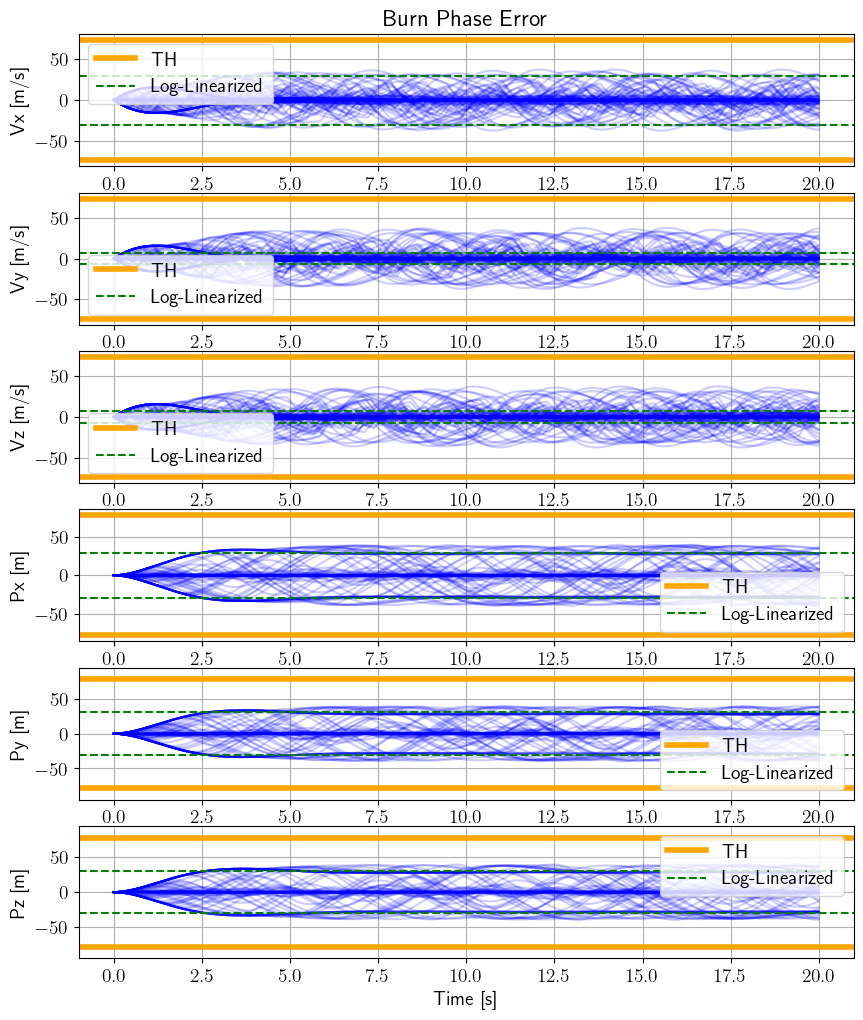

In [145]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True
def burn_plotting(data_burn, bounds):
    fig, axes = plt.subplots(6, 1, figsize=(10, 12))
    axes[0].set_title(f'Burn Phase Error')
    colors = ['r','g','b']

    # Vx
    ax_idx = 0
    data_idx = 3
    plotting.plot_burn_delta_vx_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()


    #V y
    ax_idx = 1
    data_idx = 4
    plotting.plot_burn_delta_vy_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()


    # Vz
    ax_idx = 2
    data_idx = 4
    plotting.plot_burn_delta_vz_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()

   
    # Px
    ax_idx = 3
    data_idx = 0
    plotting.plot_burn_x_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()

   
    # Py
    ax_idx = 4
    data_idx = 1
    plotting.plot_burn_y_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()

    # Add padding because out of range
    ax = axes[ax_idx]

    # current limits
    y0, y1 = ax.get_ylim()
    
    # all bound values you want visible
    vals = [
        bounds_th[data_idx, 0], bounds_th[data_idx, 1],
        bounds_log[data_idx, 0], bounds_log[data_idx, 1],
        y0, y1
    ]
    lo = min(vals)
    hi = max(vals)
    
    # add a little headroom
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    ax.set_ylim(lo - pad, hi + pad)

    # Pz
    ax_idx = 5
    data_idx = 2
    plotting.plot_burn_z_error(axes[ax_idx], data_burn)

    axes[ax_idx].axhline(bounds_th[data_idx, 0], ls='-', lw=4, color='orange', label='TH')
    axes[ax_idx].axhline(bounds_th[data_idx, 1], ls='-', lw=4, color='orange')
    
    axes[ax_idx].axhline(y=bounds_log[data_idx, 0], linestyle='--', color='green', label="Log-Linearized")
    axes[ax_idx].axhline(y=bounds_log[data_idx, 1], color='green', linestyle='--')
    axes[ax_idx].legend()

    # Out of range
    ax = axes[ax_idx]

    # current limits
    y0, y1 = ax.get_ylim()
    
    # all bound values you want visible
    vals = [
        bounds_th[data_idx, 0], bounds_th[data_idx, 1],
        bounds_log[data_idx, 0], bounds_log[data_idx, 1],
        y0, y1
    ]
    lo = min(vals)
    hi = max(vals)
    
    # add a little headroom
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    ax.set_ylim(lo - pad, hi + pad)


    
burn_plotting(data_burn, bounds)
plt.savefig("20s-10thrust-5dist.pdf", format="pdf", dpi=300)
# plt.show()
